# Prototype calculation of cabelling and mixing of density from POP data <a class="anchor" id="top"> </a>
## Table Of Contents: 
* [Calculate tendency of SST and and SSS from mixing](#first-bullet)
* [Convert to density tendency](#second-bullet)
* [Decompose into the following form](#third-bullet)
* [Save the four terms to dataset](#fourth-bullet)

(Next steps are continued in [tendency-histograms.ipynb](./tendency-histograms.ipynb)

"Horizontal density compensation in the
ocean refers to conditions where horizontal gradients of temperature and salinity balance each
other in their joint effect on density, substantially decreasing or canceling horizontal density
gradients"

-- [Koch et al., 2019](https://arxiv.org/pdf/1906.09904.pdf)

**Good Example (but for vertical Turner Angle:**


Since the rate of molecular heat diffusion is larger by two orders than that of the salt, if temperature and
salinity simultaneously increase or decrease with depth, double diffusion is observed on the boundary
between the layers [3]. In the first case, when the layer of the cold and less salty water covers the warmer
and more salty water (–90 < Tu < –45), the mixing occurs as a result of the diffusive convection, for
example, on the lower boundary of CIL in the subarctic water structure. On the contrary, if 45 < Tu < 90,
when the warmer and more salty water covers the cold and less salty water, the mixing takes place due to
the “salty fingers” convection. As a rule, such situation arises in the upper layers of the ocean in the case of
the carryover of warm and salty subtropical water to the limits of the subarctic water in the area of the
subarctic front.

-- [Pacific Research Fisheries Center 2013](https://link.springer.com/content/pdf/10.3103/S1068373913100063.pdf)

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import gcsfs

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_w: 62,
                         z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/59)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SFWF_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SHF_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSH_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUX_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUY_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  13088337
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2013-03-09 at 12:25:55.7
    tavg_sum:      86399.99999999962
    title:         hybrid_v5_rel04_BC5_ne120_t12_pop62

In [4]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [5]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.440985700bbc459399968765fe8579d1/status,


In [6]:
cluster.close()
client.close()

# 1) Calculate tendency of SST and and SSS from mixing <a class="anchor" id="first-bullet"> </a>

In [6]:
#from Paige's code: The biharmonic horiz diffusion routine
#https://github.com/ocean-transport/cesm-air-sea/blob/master/biharmonic_tendency.ipynb

# raw grid geometry
work1 = (ds['HTN'].values / # HTN: cell widths on North sides of T cell (cm)
         ds['HUW'].values) # HUW: cell widths on West sides of U cell (cm)
tarea = ds['TAREA'].values # TAREA: area of T cells (cm**2)
tarea_r = np.ma.masked_invalid(tarea**-1).filled(0.) # 1/area of T cells
dtn = work1*tarea_r # coefficient of north point in 5-point stencil
dts = np.roll(work1,-1,axis=0)*tarea_r # coeff of south point in 5-point stencil

work1 = (ds['HTE'].values / # HTE: cell widths on East sides of T cells (cm)
         ds['HUS'].values) # HUS: cell widths on South sides of U cells (cm)
dte = work1*tarea_r # coeff of east point in 5-point stencil
dtw = np.roll(work1,-1,axis=1)*tarea_r # coeff of west point in 5-point stencil

kmt = ds['KMT'].values # KMT: k-index of deepest grid cell on T grid (where k is the depth level)

# boundary conditions
kmt_ = kmt > 1 # k=1 is the surface, so this sets all subsurface levels to True
kmtn = np.roll(kmt_,-1,axis=0)
kmts = np.roll(kmt_,1,axis=0)
kmte = np.roll(kmt_,-1,axis=1)
kmtw = np.roll(kmt_,1,axis=1)
cn = np.where(kmt_ & kmtn, dtn, 0.) # where both kmt_ and kmtn are True, set value equal to dtn, else set to 0 -->
# --> essentially sets up a mask for land/surface points
cs = np.where(kmt_ & kmts, dts, 0.)
ce = np.where(kmt_ & kmte, dte, 0.)
cw = np.where(kmt_ & kmtw, dtw, 0.)

# Find single index where there's a min of squared latitude --> so this is probably the lat of equator
j_eq = np.argmin(ds['ULAT'].values[:,0]**2) # ULAT: array of U-grid latitudes (degrees North)
j_eq.shape

# Area of T cells / area of U cell at the equator, all raised to 1.5 power
# this is because the mixing scheme assumes the grid spacing that is at the equator, so coeffs are 1 at equator and reduce toward the poles
ahf = (tarea / ds['UAREA'].values[j_eq, 0])**1.5 # UAREA: area of U cells (cm**2)
ahf[kmt <= 1] = 0.

def laplacian(T, cn, cs, ce, cw):
    cc = -(cn + cs + ce + cw) # cn,cs,ce,cw are coeffs for laplacian
    return (
        cc * T +
        cn * np.roll(T, -1, axis=-2) +
        cs * np.roll(T, 1, axis=-2) +
        ce * np.roll(T, -1, axis=-1) +
        cw * np.roll(T, 1, axis=-1)          
    )

def biharmonic_tendency(T, ahf, cn, cs, ce, cw):
    ah=-3e17 # horizontal tracer mixing coefficient 
    d2tk = ahf * laplacian(T, cn, cs, ce, cw) # take laplacian of T, multiplying by grid factor due to equator
    return ah * laplacian(d2tk, cn, cs, ce, cw) # take laplacian of laplacian of T

/tmp/ipykernel_414/320061692.py:37: RuntimeWarning: invalid value encountered in power
  ahf = (tarea / ds['UAREA'].values[j_eq, 0])**1.5 # UAREA: area of U cells (cm**2)


In [7]:
arr = [ahf, cn, cs, ce, cw]
for arr_type in arr:
    if str(type(arr_type)) == "<class 'numpy.ndarray'>":
        print("True")
    else:
        print("not ndarray")


True
True
True
True
True


In [8]:
SST_bih = xr.DataArray(
    dsa.map_blocks(biharmonic_tendency, ds.SST.data, ahf, cn, cs, ce, cw, 
                   dtype=ds.SST.data.dtype),
    dims=ds.SST.dims,
    coords=ds.SST.reset_coords(drop=True).coords
)
SST_bih

<xarray.DataArray 'biharmonic_tendency-190897fe493e4132eeb8e1c8ca1ee131' (
                                                                          time: 14965,
                                                                          nlat: 2400,
                                                                          nlon: 3600)>
dask.array<biharmonic_tendency, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [9]:
SSS_bih = xr.DataArray(
    dsa.map_blocks(biharmonic_tendency, ds.SSS.data, ahf, cn, cs, ce, cw, 
                   dtype=ds.SSS.data.dtype),
    dims=ds.SSS.dims,
    coords=ds.SSS.reset_coords(drop=True).coords
)
SSS_bih

<xarray.DataArray 'biharmonic_tendency-9fc0046a2fac291692b71988d8a970c4' (
                                                                          time: 14965,
                                                                          nlat: 2400,
                                                                          nlon: 3600)>
dask.array<biharmonic_tendency, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

[Back to top](#top)

# 2) Convert to density tendency <a class="anchor" id='second-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S)
$$

In [10]:
#for a single timestep to save computation cost
sst = ds.SST
sss = ds.SSS

In [11]:
drhodt = xr.apply_ufunc(jmd95numba.drhodt, sss, sst, 0,
                        output_dtypes=[sst.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()
drhods = xr.apply_ufunc(jmd95numba.drhods, sss, sst, 0,
                        output_dtypes=[sss.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()

In [12]:
dens_tend = drhodt * SST_bih + drhods * SSS_bih
dens_tend

<xarray.DataArray (time: 14965, nlat: 2400, nlon: 3600)>
dask.array<add, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

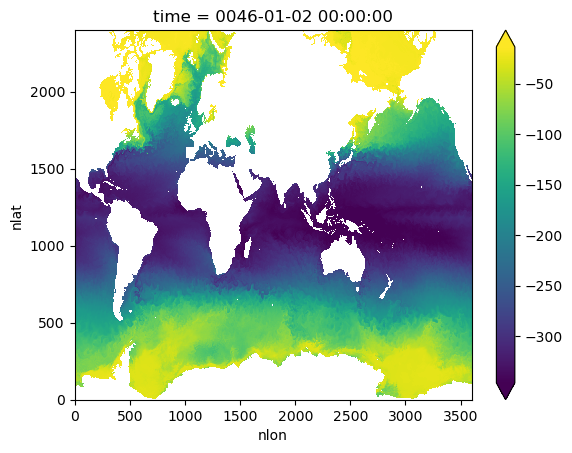

In [19]:
(rho*drhodt)[0].plot(robust=True)

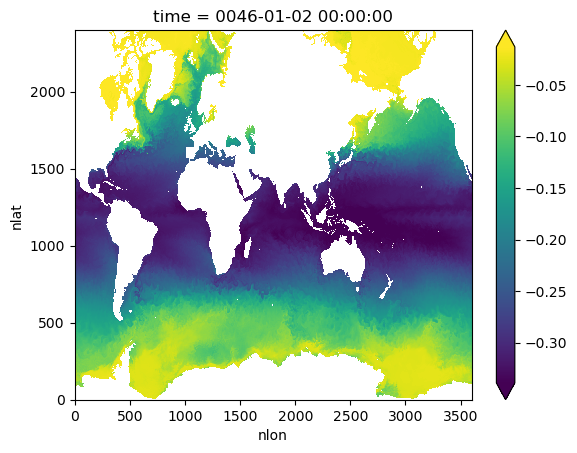

In [15]:
drhodt[0].plot(robust=True)

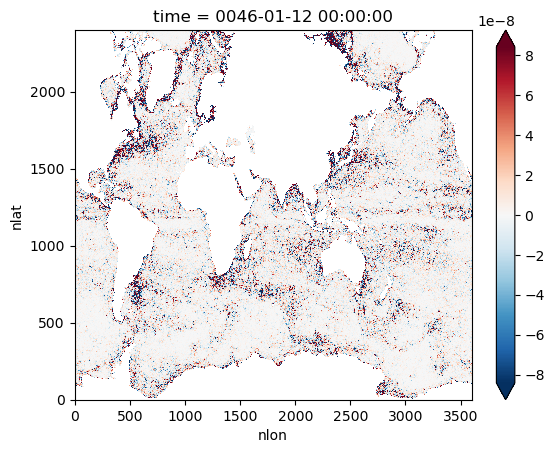

In [13]:
dens_tend.isel(time=10).plot(robust=True);

[Back to top](#top)

# 3) Decompose into the following form <a class='anchor' id='third-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) = M(\rho) + C
$$

You can calculate $C$ as

$$
C = \frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) - M(\rho)
$$

In [16]:
rho = xr.apply_ufunc(jmd95numba.rho, ds.SSS, ds.SST, 0,
                        output_dtypes=[ds.SST.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load())

In [17]:
rho

<xarray.DataArray (time: 14965, nlat: 2400, nlon: 3600)>
dask.array<transpose, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [14]:
rho_bih = xr.DataArray(dsa.map_blocks(biharmonic_tendency, rho.data, ahf, cn, cs, ce, cw, 
                                      dtype=rho.data.dtype),
                       dims=rho.dims,
                       coords=rho.reset_coords(drop=True).coords)

rho_bih

<xarray.DataArray 'biharmonic_tendency-74edaac092e1e5b5325c915b94fb8a82' (
                                                                          time: 14965,
                                                                          nlat: 2400,
                                                                          nlon: 3600)>
dask.array<biharmonic_tendency, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

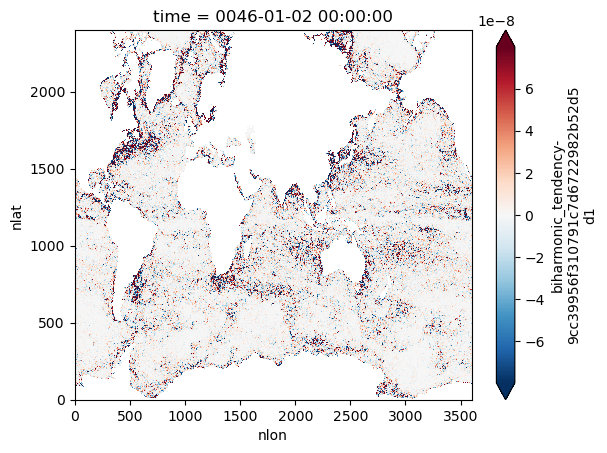

In [17]:
rho_bih[0].plot(robust=True);

In [15]:
cabbeling = dens_tend - rho_bih

In [16]:
cabbeling

<xarray.DataArray (time: 14965, nlat: 2400, nlon: 3600)>
dask.array<sub, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [17]:
selection = dict(time=0, nlat=slice(1400,1700), nlon=slice(300,500))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

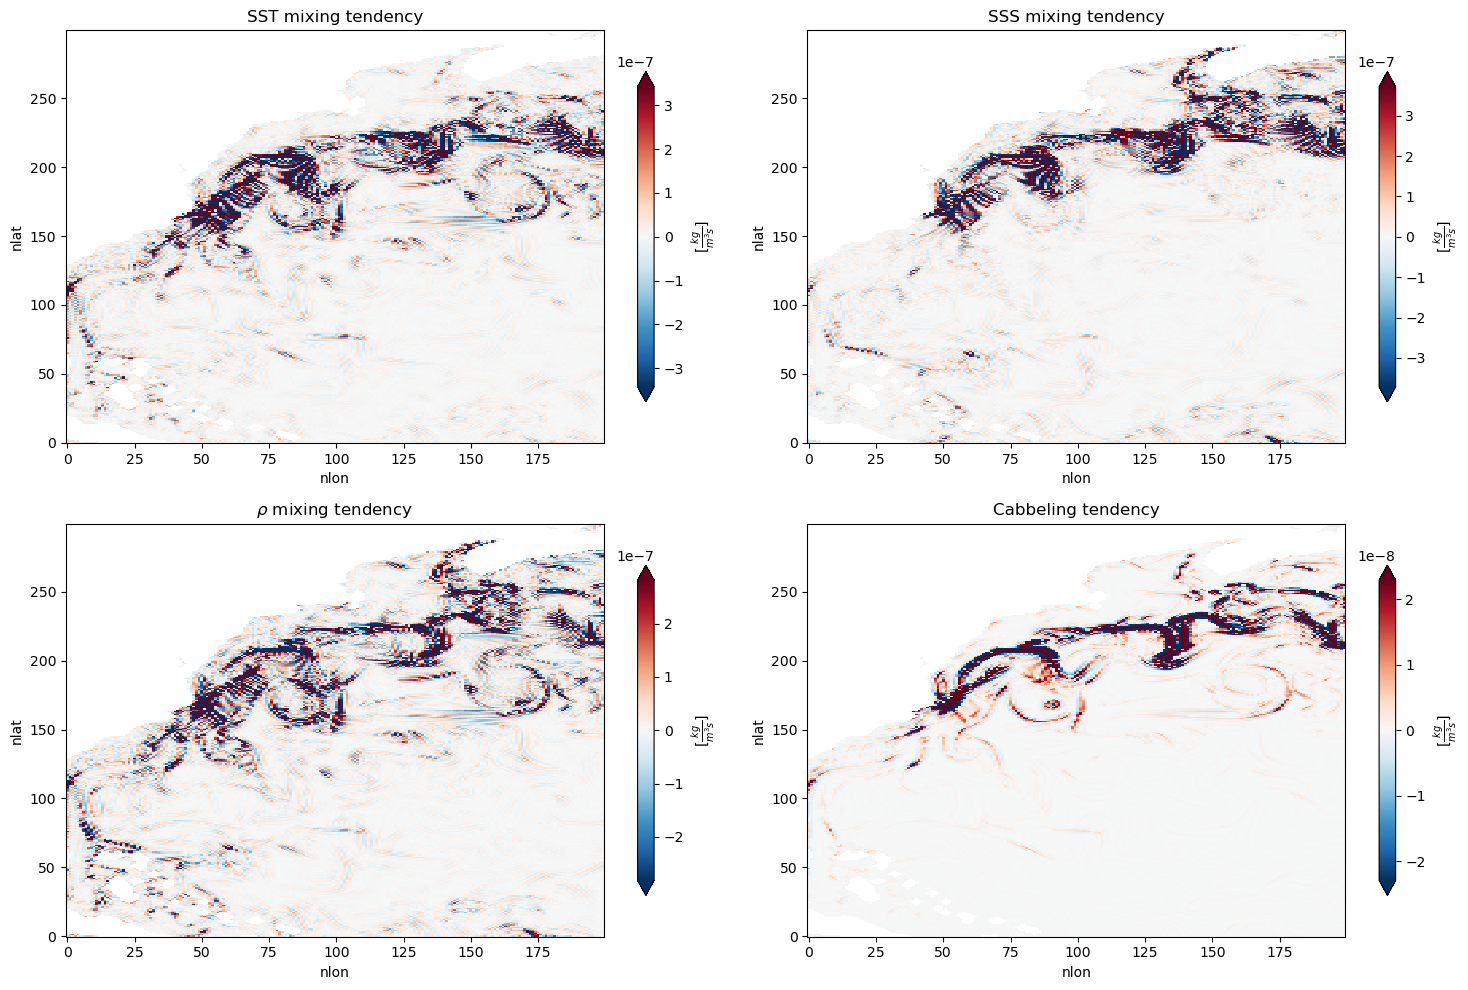

In [22]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

(SST_bih*drhodt).isel(**selection).plot(robust=True, ax=ax[0,0], 
                                 cbar_kwargs=kwargs)
ax[0,0].set_title('SST mixing tendency')
(SSS_bih*drhods).isel(**selection).plot(robust=True, ax=ax[0,1], 
                                 cbar_kwargs=kwargs)
ax[0,1].set_title('SSS mixing tendency')
(rho_bih).isel(**selection).plot(robust=True, ax=ax[1,0], 
                                 cbar_kwargs=kwargs)
ax[1,0].set_title(r'$\rho$ mixing tendency')
(cabbeling).isel(**selection).plot(robust=True, ax=ax[1,1], 
                                   cbar_kwargs=kwargs)
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();

## Create contours to overlay on above figs

In [23]:
def plot_contours_tend_terms(axis, tend_term):
    """Plot surface density contours and tendency terms"""
    c = rho.isel(**selection).plot.contour(levels=np.arange(1021, 1027), colors='grey', linestyles='dashed', ax=axis)
    plt.clabel(c)
    tend_term.isel(**selection).plot(robust=True, ax=axis,
                                     cbar_kwargs=kwargs)

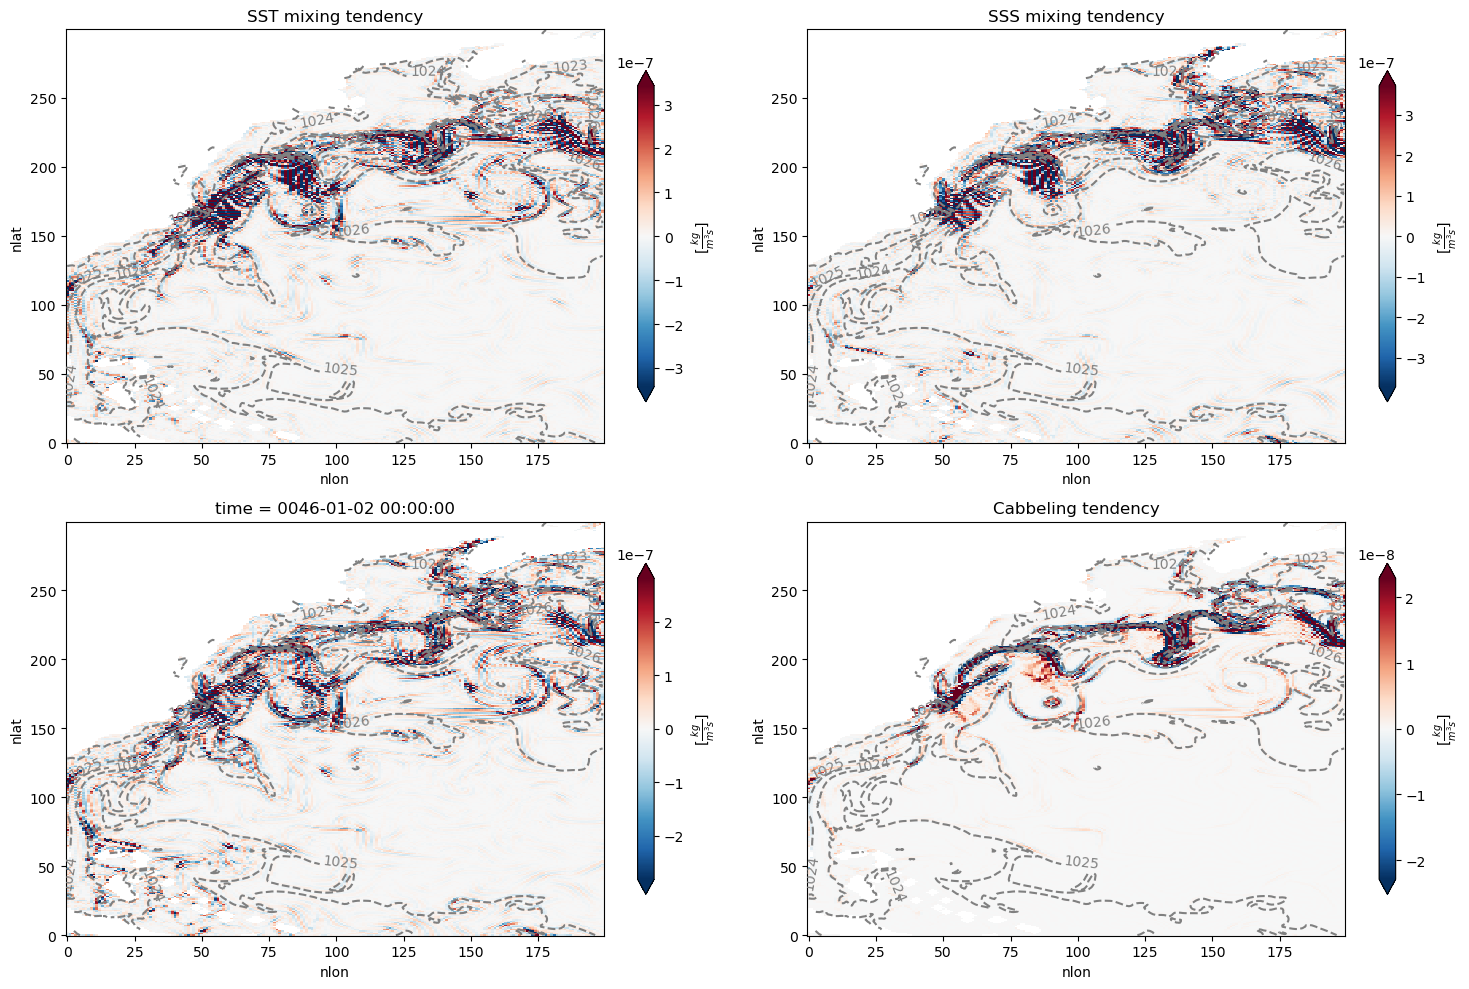

In [24]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

plot_contours_tend_terms(ax[0,0], SST_bih*drhodt)
ax[0,0].set_title('SST mixing tendency')

plot_contours_tend_terms(ax[0,1], SSS_bih*drhods)
ax[0,1].set_title('SSS mixing tendency')

plot_contours_tend_terms(ax[1,0], rho_bih)
ax[1,1].set_title(r'$\rho$ mixing tendency')

plot_contours_tend_terms(ax[1,1], cabbeling)
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();

[Back to top](#top)

## 4) Save the four terms to dataset <a class="anchor" id="fourth-bullet"> </a>

In [ ]:
client.restart()

In [18]:
tendencies = xr.merge([SST_bih.rename('SST_bih'), SSS_bih.rename('SSS_bih'),
                       drhodt.rename('drhodt'), drhods.rename('drhods'), 
                       rho_bih.rename('rho_bih'), cabbeling.rename('cabbeling')])
tendencies

tendencies_new_coords = tendencies.assign_coords(coords={'time':tendencies.time, 
                                                         'nlat':tendencies.nlat, 
                                                         'nlon':tendencies.nlon})
tendencies_new_coords

<xarray.Dataset>
Dimensions:    (time: 14965, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
Data variables:
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [19]:
tracers = xr.merge([tendencies_new_coords.SST_bih.rename('SST_bih'), 
                    tendencies_new_coords.SSS_bih.rename('SSS_bih')])
drhodts = xr.merge([tendencies_new_coords.drhodt.rename('drhodt'), 
                    tendencies_new_coords.drhods.rename('drhods')])
rho_bih_cab = xr.merge([tendencies_new_coords.rho_bih.rename('rho_bih'), 
                        tendencies_new_coords.cabbeling.rename('cabbeling')])

In [26]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [34]:
#uploading tracer tendency ds for entire 40 yr run
gcsmap_tracer_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tracer_tendencies_40yr.zarr')
tracers.to_zarr(gcsmap_tracer_tendencies, mode='w')

In [35]:
#uploading drhodts tendency ds for entire 40 yr run
gcsmap_drhodts_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr')
drhodts.to_zarr(gcsmap_drhodts_tendencies, mode='w')

In [36]:
#uploading rho_bih and cabbeling tendency ds for entire 40 yr run
gcsmap_rho_cab_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/rho_bih_cab_tendencies_40yr.zarr')
rho_bih_cab.to_zarr(gcsmap_rho_cab_tendencies, mode='w')

In [38]:
cluster.close()
client.close()

[Back to top](#top)